In [38]:
import mysql
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt 
import requests 
import numpy as np 
import cv2 
from io import BytesIO
import os
import glob

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F

from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [39]:
torch.manual_seed(1)

In [40]:
# csv -> DataFrame 변환
df = pd.read_csv('movieDF.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9901 entries, 0 to 9900
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9901 non-null   int64  
 1   ko_name       9901 non-null   object 
 2   en_name       9744 non-null   object 
 3   year          9900 non-null   float64
 4   country       9901 non-null   object 
 5   grade         9625 non-null   object 
 6   genre         9901 non-null   object 
 7   runtime       9901 non-null   int64  
 8   release_date  9898 non-null   object 
 9   audience      9901 non-null   int64  
 10  director      9885 non-null   object 
 11  story         9897 non-null   object 
 12  poster_link   9901 non-null   object 
dtypes: float64(1), int64(3), object(9)
memory usage: 1005.7+ KB


In [41]:
# 장르 종류 리스트화
genre = df['genre']

genre_columns = set()
for i in genre:
    split_list = i.split(', ')
    for j in split_list:
        genre_columns.add(j)

genre_list = list(genre_columns)

# 장르 종류 개수
print(len(genre_list))
print(genre_list)

35
['느와르', '3D', '추리', '시대극', '애니메이션', '판타지', '뮤지컬', '스포츠', '어드벤처', '공포', '가족', '블록버스터', '스릴러', '무협', '멜로·로맨스', '실험영화', '서스펜스', '범죄', '전기', '실화', '모험', '액션', '미스터리', '서부', '다큐멘터리', '퀴어', '역사·서사', '자연재해', '드라마', 'SF', '스파이', '뮤직', '옴니버스', '코미디', '전쟁']


In [42]:
# 다중 레이블 장르 원-핫 인코딩
total_one_hot_list = []
for i in genre:
    split_list = i.split(', ')
    one_hot_list = [0] * len(genre_list)
    for j in split_list:
        for index, value in enumerate(genre_list):
            if j == value:
                one_hot_list[index] += 1
    total_one_hot_list.append(one_hot_list)

In [43]:
target_one_hot = pd.DataFrame(total_one_hot_list, columns=genre_list)
target_one_hot.head()

,느와르,3D,추리,시대극,애니메이션,판타지,뮤지컬,스포츠,어드벤처,공포,...,퀴어,역사·서사,자연재해,드라마,SF,스파이,뮤직,옴니버스,코미디,전쟁
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [44]:
# 장르별 빈도수 확인
print(target_one_hot.sum(axis=0))

느와르         47
3D          34
추리           7
시대극         27
애니메이션      900
판타지        489
뮤지컬        118
스포츠         25
어드벤처       159
공포         534
가족         217
블록버스터      133
스릴러        851
무협          73
멜로·로맨스    1619
실험영화         1
서스펜스         6
범죄        1326
전기          16
실화          12
모험           4
액션        1882
미스터리       478
서부          32
다큐멘터리      546
퀴어           3
역사·서사       22
자연재해         2
드라마       4549
SF         473
스파이          1
뮤직         116
옴니버스        27
코미디       1883
전쟁         173
dtype: int64


빈도수가 너무 적은 장르들이 많다

In [45]:
# 빈도수가 적은 장르 '그 외'로 통합
cols = ['뮤지컬', '전쟁', '뮤직', '3D', '스포츠', '어드벤처', '스파이', '블록버스터', '추리',
        '가족', '자연재해', '퀴어', '실험영화', '느와르', '실화', '옴니버스', '시대극', '전기',
        '서스펜스', '무협', '모험', '모험', '역사·서사', '서부']
target_one_hot['그 외'] = [1 if i >= 1 else 0 for i in target_one_hot[cols].sum(axis=1)]
target_one_hot_scaled = target_one_hot.drop(cols, axis=1)
target_one_hot_scaled['id'] = df['id']
target_one_hot_scaled

,애니메이션,판타지,공포,스릴러,멜로·로맨스,범죄,액션,미스터리,다큐멘터리,드라마,SF,코미디,그 외,id
0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
1,0,0,0,0,0,1,1,0,0,1,0,0,0,2
2,0,0,0,0,1,0,0,0,0,0,0,1,0,3
3,0,0,0,0,1,0,0,0,0,1,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,0,1,61787
9897,0,0,0,0,0,0,0,0,0,0,0,0,1,61796
9898,0,0,0,0,0,0,0,0,1,0,0,0,0,61797
9899,0,0,0,0,0,0,0,0,0,0,0,0,1,61804


In [46]:
target_one_hot_scaled[target_one_hot_scaled['드라마'] == 2]

,애니메이션,판타지,공포,스릴러,멜로·로맨스,범죄,액션,미스터리,다큐멘터리,드라마,SF,코미디,그 외,id
2888,0,0,0,0,0,0,0,0,0,2,0,0,0,12094
5567,0,0,0,0,0,0,0,0,0,2,0,0,0,38643
6721,0,0,0,0,0,0,0,0,0,2,0,0,0,46577


아놔... 빈도가 2 이상인 장르가 있다... 홈페이지를 보니 실수를 한 것 같다... (드라마, 드라마) 이런 식으로 적어놨는데 제기랄...

In [47]:
for i in target_one_hot_scaled.columns[:-1]:
    target_one_hot_scaled[i] = [1 if i >= 1 else 0 for i in target_one_hot_scaled[i]]

for i in target_one_hot_scaled.columns[:-1]:
    print(target_one_hot_scaled[i].value_counts())

애니메이션
0    9003
1     898
Name: count, dtype: int64
판타지
0    9412
1     489
Name: count, dtype: int64
공포
0    9367
1     534
Name: count, dtype: int64
스릴러
0    9050
1     851
Name: count, dtype: int64
멜로·로맨스
0    8282
1    1619
Name: count, dtype: int64
범죄
0    8575
1    1326
Name: count, dtype: int64
액션
0    8020
1    1881
Name: count, dtype: int64
미스터리
0    9423
1     478
Name: count, dtype: int64
다큐멘터리
0    9355
1     546
Name: count, dtype: int64
드라마
0    5355
1    4546
Name: count, dtype: int64
SF
0    9428
1     473
Name: count, dtype: int64
코미디
0    8019
1    1882
Name: count, dtype: int64
그 외
0    8723
1    1178
Name: count, dtype: int64


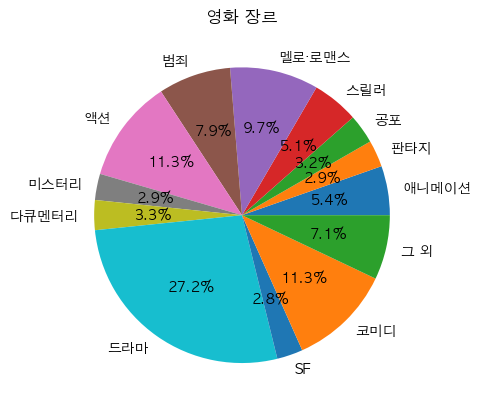

In [48]:
value = target_one_hot_scaled.drop('id', axis=1).sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('영화 장르')
plt.show()

드라마 장르가 너무 많다

In [49]:
# 드라마 제외한 장르 선택 후 중강
no_drama = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]
total_target = pd.concat([target_one_hot_scaled, no_drama, no_drama], axis=0).drop('id', axis=1)
total_target.sum(axis=0)

애니메이션     2616
판타지       1199
공포        1534
스릴러       2243
멜로·로맨스    3253
범죄        2950
액션        4769
미스터리      1132
다큐멘터리     1596
드라마       4546
SF        1283
코미디       4392
그 외       2678
dtype: int64

In [50]:
total_target

,애니메이션,판타지,공포,스릴러,멜로·로맨스,범죄,액션,미스터리,다큐멘터리,드라마,SF,코미디,그 외
0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,0,0,0,0,0,1,1,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,0,1
9897,0,0,0,0,0,0,0,0,0,0,0,0,1
9898,0,0,0,0,0,0,0,0,1,0,0,0,0
9899,0,0,0,0,0,0,0,0,0,0,0,0,1


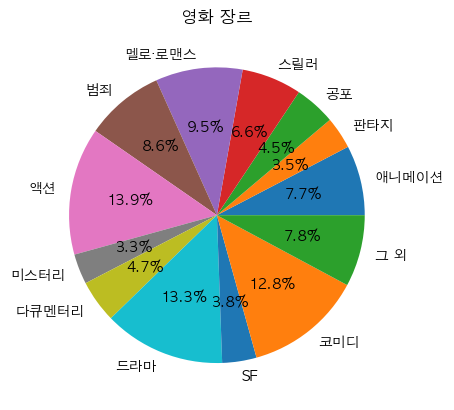

In [51]:
value = total_target.sum(axis=0)
plt.rc('font', family='AppleGothic')
plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('영화 장르')
plt.show()

아직 불균형이 존재하긴 하지만 이전에 비해서는 개선되었다

In [52]:
len(df)

9901

In [53]:
# # 포스터 저장
# idx = 0
# poster_link = df['poster_link'][idx:]
# for index, link in enumerate(poster_link):
#     response = requests.get(link)
#     img = Image.open(BytesIO(response.content))
#     RGB_img = img.convert('RGB')
#     id = df['id'][index+idx]
#     safe_name = df['ko_name'][index+idx].replace('/', ' ')
#     RGB_img.save(f"/Users/anhyojun/WorkSpace/LocalData/영화 포스터/{id}_{safe_name}.jpg")

In [54]:
# # 이미지 증강
# no_drama_id = target_one_hot_scaled[target_one_hot_scaled['드라마'] == 0]['id']
# poster_path = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/'

# flip = transforms.RandomHorizontalFlip(p=1)
# elastic = transforms.ElasticTransform()

# for id in no_drama_id.values:
#     name = df[df['id'] == id]['ko_name'].iloc[0].replace('/', ' ')
#     img = Image.open(f"{poster_path}{id}_{name}.jpg")
#     flip_img = flip(img)
#     elastic_img = elastic(img)
#     save_path1 = f'/Users/anhyojun/WorkSpace/LocalData/영화 포스터 반전/{id}_{name}_reverse.jpg'
#     save_path2 = f'/Users/anhyojun/WorkSpace/LocalData/영화 포스터 왜곡/{id}_{name}_elastic.jpg'
#     flip_img.save(save_path1)
#     elastic_img.save(save_path2)

In [55]:
# 이미지 폴더 경로
poster_path1 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터'
poster_path2 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 반전'
poster_path3 = '/Users/anhyojun/WorkSpace/LocalData/영화 포스터 왜곡'

# 폴더 리스트
poster_paths = [poster_path1, poster_path2, poster_path3]

In [56]:
all_poster_path = []

for path in poster_paths:
    path_list = glob.glob(f"{path}/*.jpg")
    sorted_path = sorted(path_list, key=lambda x : int(x.split('_')[0].split('/')[-1]))
    all_poster_path.extend(sorted_path)

In [57]:
all_poster_path

['/Users/anhyojun/WorkSpace/LocalData/영화 포스터/1_히트.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/2_랜섬.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/3_귀여운 여인.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/4_라스베가스를 떠나며.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/5_보디가드.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/6_고양이와 개에 관한 진실.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/7_아기공룡 둘리: 얼음별 대모험 리마스터링.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/8_인형의 집으로 오세요.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/9_인디펜던스 데이.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/11_마이클 콜린스.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/12_트레인스포팅.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/13_센스 앤 센서빌리티.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/14_공각기동대.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/17_율리시즈의 시선.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/19_미지왕.jpg',
 '/Users/anhyojun/WorkSpace/LocalData/영화 포스터/20_브레이킹 더 웨이브.jpg',
 '

In [58]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labelsDF, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = np.array(labelsDF)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            input_tensor = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float)

        return input_tensor, label_tensor

In [59]:
target_one_hot_scaled

,애니메이션,판타지,공포,스릴러,멜로·로맨스,범죄,액션,미스터리,다큐멘터리,드라마,SF,코미디,그 외,id
0,0,0,0,0,0,1,1,0,0,1,0,0,0,1
1,0,0,0,0,0,1,1,0,0,1,0,0,0,2
2,0,0,0,0,1,0,0,0,0,0,0,1,0,3
3,0,0,0,0,1,0,0,0,0,1,0,0,0,4
4,0,0,0,0,1,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,0,1,61787
9897,0,0,0,0,0,0,0,0,0,0,0,0,1,61796
9898,0,0,0,0,0,0,0,0,1,0,0,0,0,61797
9899,0,0,0,0,0,0,0,0,0,0,0,0,1,61804


In [60]:
all_poster_path = all_poster_path
no_drama_drop = no_drama.drop('id', axis=1)
total_target = pd.concat([target_one_hot_scaled.drop('id', axis=1), no_drama_drop, no_drama_drop], axis=0)
total_target

,애니메이션,판타지,공포,스릴러,멜로·로맨스,범죄,액션,미스터리,다큐멘터리,드라마,SF,코미디,그 외
0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,0,0,0,0,0,1,1,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9896,0,0,0,0,0,0,0,0,0,0,0,0,1
9897,0,0,0,0,0,0,0,0,0,0,0,0,1
9898,0,0,0,0,0,0,0,0,1,0,0,0,0
9899,0,0,0,0,0,0,0,0,0,0,0,0,1


In [61]:
train_path, test_path, train_label, test_label = train_test_split(all_poster_path, total_target,
                                                                  test_size = 0.2, random_state = 42)
train_path, valid_path, train_label, valid_label = train_test_split(train_path, train_label,
                                                                    test_size = 0.2, random_state = 42)
print(f"train_label.shape {train_label.shape}")
print(f"valid_label.shape {valid_label.shape}")
print(f"test_label.shape {test_label.shape}")

train_label.shape (13190, 13)
valid_label.shape (3298, 13)
test_label.shape (4123, 13)


In [62]:
# 이미지 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 정규화 값
])

trainDS = CustomImageDataset(train_path, train_label, transform)
validDS = CustomImageDataset(valid_path, valid_label, transform)
testDS = CustomImageDataset(test_path, test_label, transform)

trainDL = DataLoader(trainDS, batch_size=32, shuffle=True)
validDL = DataLoader(validDS, batch_size=32, shuffle=True)
testDL = DataLoader(testDS, batch_size=32, shuffle=True)

In [37]:
plt.imshow(trainDL.dataset[9][0].permute(1,2,0))
plt.show()

NameError: name 'trainDL' is not defined

In [81]:
# 미리 학습된 ResNet 모델 불러오기 (weight 사용)
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 전결합층 가중치 변경하도록 설정
for param in model.fc.parameters():
    param.requires_grad = True

In [82]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [83]:
# 마지막 레이어 (full connected layer) 교체 (클래스 5개로 변경)
num_features = model.fc.in_features # 2048
model.fc = nn.Linear(num_features, 13) # 입력은 이전 층의 아웃을 그대로 받고 출력은 방법대 인원

# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 14)
# )

In [84]:
# from torchvision.models import efficientnet_b0

# model = efficientnet_b0(pretrained=True)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 14)

In [85]:
# MPS 사용 여부 확인하기
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device : {device}")

device : mps


In [88]:
# 훈련
EPOCH = 100
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/개인 프로젝트/ResNet50'

# 옵티마이저를 모델 파라미터에 대해 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)

result = training(trainDL, validDL, model, model_type = 'multilabel', optimizer = optimizer, epoch = EPOCH,
                  endurance_cnt = 10, view_epoch = 1, num_classes = 13, SAVE_PATH = SAVE_PATH, MPS = True, device = device)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.2967, Test : 0.2861
[Score  : 1/100] Train : 0.2655, Test : 0.3024
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.2839, Test : 0.2842
[Score  : 2/100] Train : 0.3500, Test : 0.4180
[EPOCH] : 3에서 모델 저장 완료.
[Loss : 3/100] Train : 0.2772, Test : 0.2835
[Score  : 3/100] Train : 0.3812, Test : 0.4048
[EPOCH] : 4에서 모델 저장 완료.
[Loss : 4/100] Train : 0.2729, Test : 0.2784
[Score  : 4/100] Train : 0.4008, Test : 0.4036
[EPOCH] : 5에서 모델 저장 완료.
[Loss : 5/100] Train : 0.2694, Test : 0.2738
[Score  : 5/100] Train : 0.4148, Test : 0.4099
[Loss : 6/100] Train : 0.2666, Test : 0.2797
[Score  : 6/100] Train : 0.4211, Test : 0.3860
[Loss : 7/100] Train : 0.2630, Test : 0.2743
[Score  : 7/100] Train : 0.4359, Test : 0.3755
[EPOCH] : 8에서 모델 저장 완료.
[Loss : 8/100] Train : 0.2606, Test : 0.2733
[Score  : 8/100] Train : 0.4405, Test : 0.4206
[EPOCH] : 9에서 모델 저장 완료.
[Loss : 9/100] Train : 0.2584, Test : 0.2728
[Score  : 9/100] Train : 0.4458, Test : 0.4180
[Los

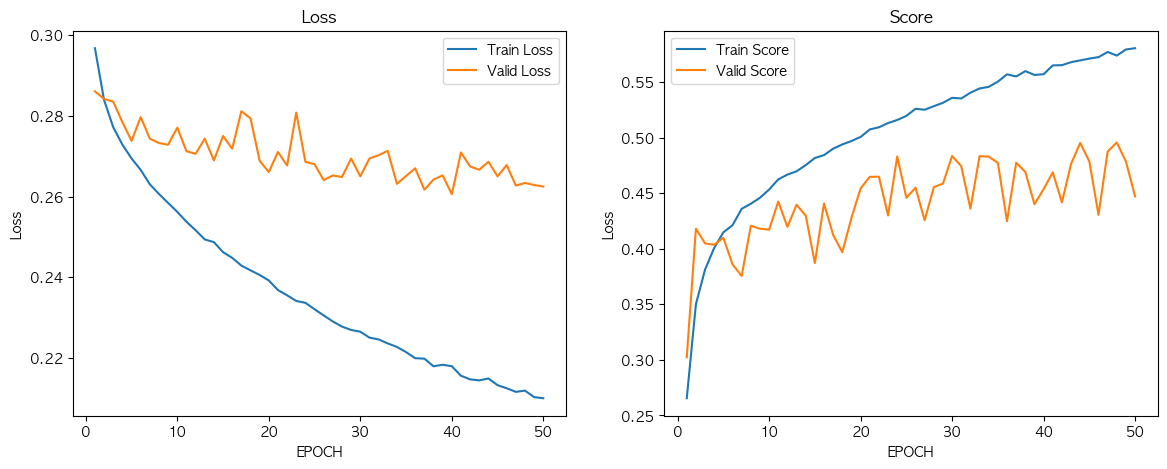

In [91]:
DrawPlot(result)
plt.show()